In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import string


In [32]:
# Load datasets
supervised_data = pd.read_csv('/content/drive/MyDrive/output.csv')
unsupervised_train = pd.read_json('/content/drive/MyDrive/webis-clickbait-22/train.jsonl', lines=True)
unsupervised_val = pd.read_json('/content/drive/MyDrive/webis-clickbait-22/validation.jsonl', lines=True)

In [33]:
# Separate features and labels
X = supervised_data[' title']
y = supervised_data['label']

In [34]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [36]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=100)
X_test_padded = pad_sequences(X_test_seq, maxlen=100)

In [38]:
# Build and compile the RNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          640000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           12352     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 660673 (2.52 MB)
Trainable params: 660673 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# Train the RNN model with validation data
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
720/720 [==============================] - 72s 93ms/step - loss: 0.1428 - accuracy: 0.9386 - val_loss: 0.0835 - val_accuracy: 0.9695
Epoch 2/5
720/720 [==============================] - 66s 91ms/step - loss: 0.0339 - accuracy: 0.9887 - val_loss: 0.0994 - val_accuracy: 0.9680
Epoch 3/5
720/720 [==============================] - 62s 86ms/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.1209 - val_accuracy: 0.9691
Epoch 4/5
720/720 [==============================] - 63s 88ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.1295 - val_accuracy: 0.9699
Epoch 5/5
720/720 [==============================] - 63s 88ms/step - loss: 0.0252 - accuracy: 0.9907 - val_loss: 0.1324 - val_accuracy: 0.9527


In [40]:

# Evaluate the RNN model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test accuracy: {test_accuracy}")

200/200 [==============================] - 4s 19ms/step - loss: 0.1138 - accuracy: 0.9570
Test accuracy: 0.9570178389549255


In [41]:
# Predict on the test set
y_test_pred_probs = model.predict(X_test_padded)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

200/200 [==============================] - 4s 20ms/step


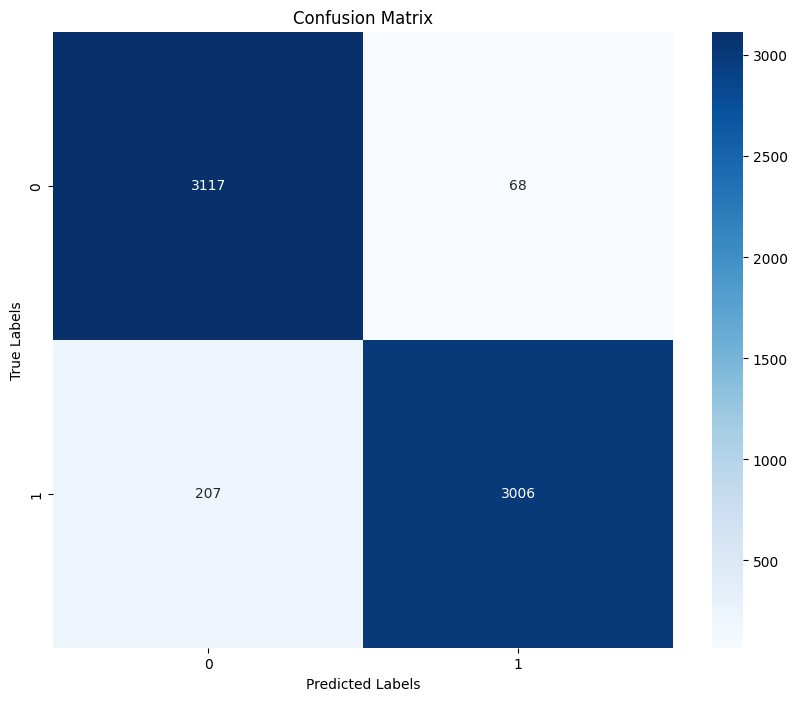

In [42]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Extract relevant text features from the unsupervised datasets
X_unlabeled_train = unsupervised_train['postText'].astype(str)
X_unlabeled_val = unsupervised_val['postText'].astype(str)

In [44]:
# Tokenize and pad the unsupervised data
X_unlabeled_train_seq = tokenizer.texts_to_sequences(X_unlabeled_train)
X_unlabeled_val_seq = tokenizer.texts_to_sequences(X_unlabeled_val)
X_unlabeled_train_padded = pad_sequences(X_unlabeled_train_seq, maxlen=100)
X_unlabeled_val_padded = pad_sequences(X_unlabeled_val_seq, maxlen=100)

In [45]:
# Predict pseudo-labels for the unsupervised training data
pseudo_labels_train_probs = model.predict(X_unlabeled_train_padded)
pseudo_labels_train = (pseudo_labels_train_probs > 0.5).astype(int).flatten()

100/100 [==============================] - 3s 29ms/step


In [46]:
# Select high-confidence samples for self-training
confidence_threshold = 0.8
high_confidence_idx_train = pseudo_labels_train_probs.flatten() >= confidence_threshold

In [47]:
# Combine high-confidence pseudo-labeled data with original training data
X_combined_train = np.concatenate([X_train_padded, X_unlabeled_train_padded[high_confidence_idx_train]])
y_combined_train = np.concatenate([y_train, pseudo_labels_train[high_confidence_idx_train]])

In [48]:
# Retrain the model on the combined dataset
history_retraining=model.fit(X_combined_train, y_combined_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
763/763 [==============================] - 67s 88ms/step - loss: 0.0374 - accuracy: 0.9875 - val_loss: 0.1046 - val_accuracy: 0.9583
Epoch 2/5
763/763 [==============================] - 64s 84ms/step - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.0929 - val_accuracy: 0.9735
Epoch 3/5
763/763 [==============================] - 64s 84ms/step - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.0947 - val_accuracy: 0.9709
Epoch 4/5
763/763 [==============================] - 64s 84ms/step - loss: 0.0389 - accuracy: 0.9863 - val_loss: 0.0755 - val_accuracy: 0.9801
Epoch 5/5
763/763 [==============================] - 65s 85ms/step - loss: 0.0158 - accuracy: 0.9943 - val_loss: 0.0829 - val_accuracy: 0.9768


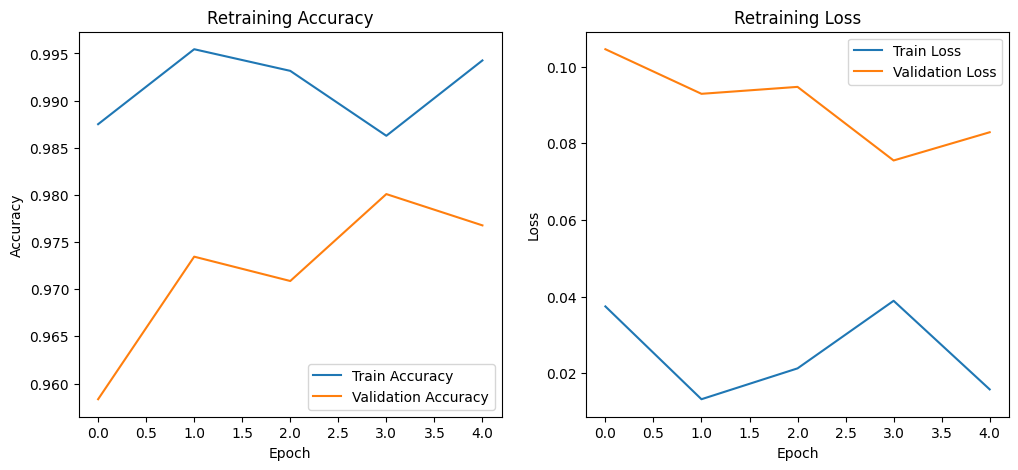

In [49]:
# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_retraining.history['accuracy'], label='Train Accuracy')
plt.plot(history_retraining.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Retraining Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_retraining.history['loss'], label='Train Loss')
plt.plot(history_retraining.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Retraining Loss')
plt.legend()

plt.show()

In [50]:
# Load and preprocess the final test set
test_data = pd.read_csv('/content/drive/MyDrive/clickbait_data.csv')

In [51]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [52]:
test_data['headline'] = test_data['headline'].apply(preprocess_text)
X_test_final = test_data['headline']
y_test_final = test_data['clickbait']
y_test_final = label_encoder.transform(y_test_final)


In [53]:
X_test_final_seq = tokenizer.texts_to_sequences(X_test_final)
X_test_final_padded = pad_sequences(X_test_final_seq, maxlen=100)

In [54]:
# Evaluate the model on the final test set
test_loss_final, test_accuracy_final = model.evaluate(X_test_final_padded, y_test_final)
print(f"Final Test accuracy: {test_accuracy_final}")

1000/1000 [==============================] - 20s 20ms/step - loss: 0.0520 - accuracy: 0.9851
Final Test accuracy: 0.9851250052452087


In [55]:
# Predict on the final test set
y_test_final_pred_probs = model.predict(X_test_final_padded)
y_test_final_pred = (y_test_final_pred_probs > 0.5).astype(int).flatten()

1000/1000 [==============================] - 20s 20ms/step


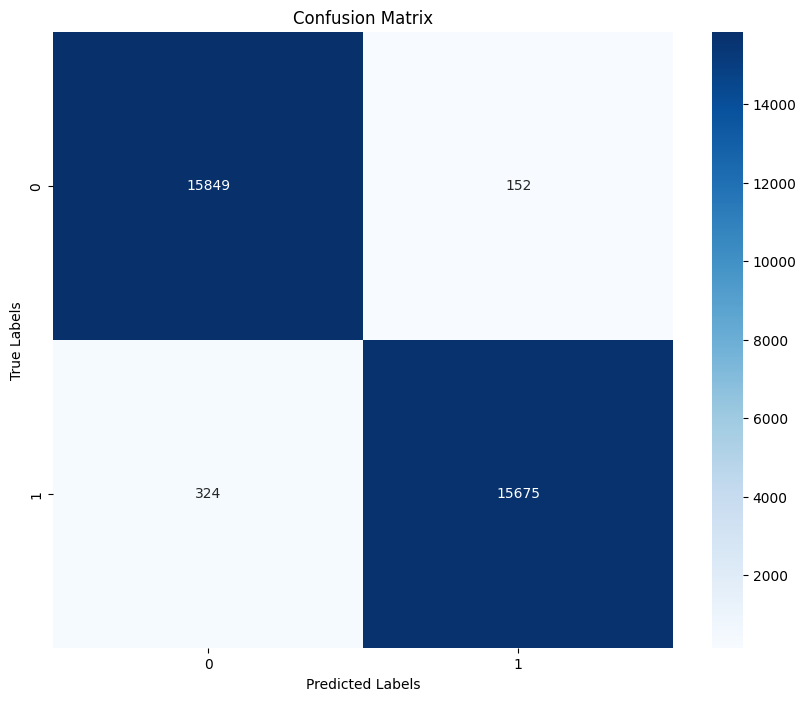

In [56]:
# Compute the confusion matrix for the final test set
conf_matrix_final = confusion_matrix(y_test_final, y_test_final_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()